In [2]:
# 기본 라이브러리 import
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler        # 표쥰화 스케일러(평균 0, 표준편차 1)

In [ ]:
# csv 파일 불러와서 DataFrame으로 저장
df = pd.read_csv("./data/fetch_california_housing.csv")
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [ ]:
# 컬럼명 MedHouseVal -> Target 변경

df = df.rename(columns={"MedHouseVal":"Target"})
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


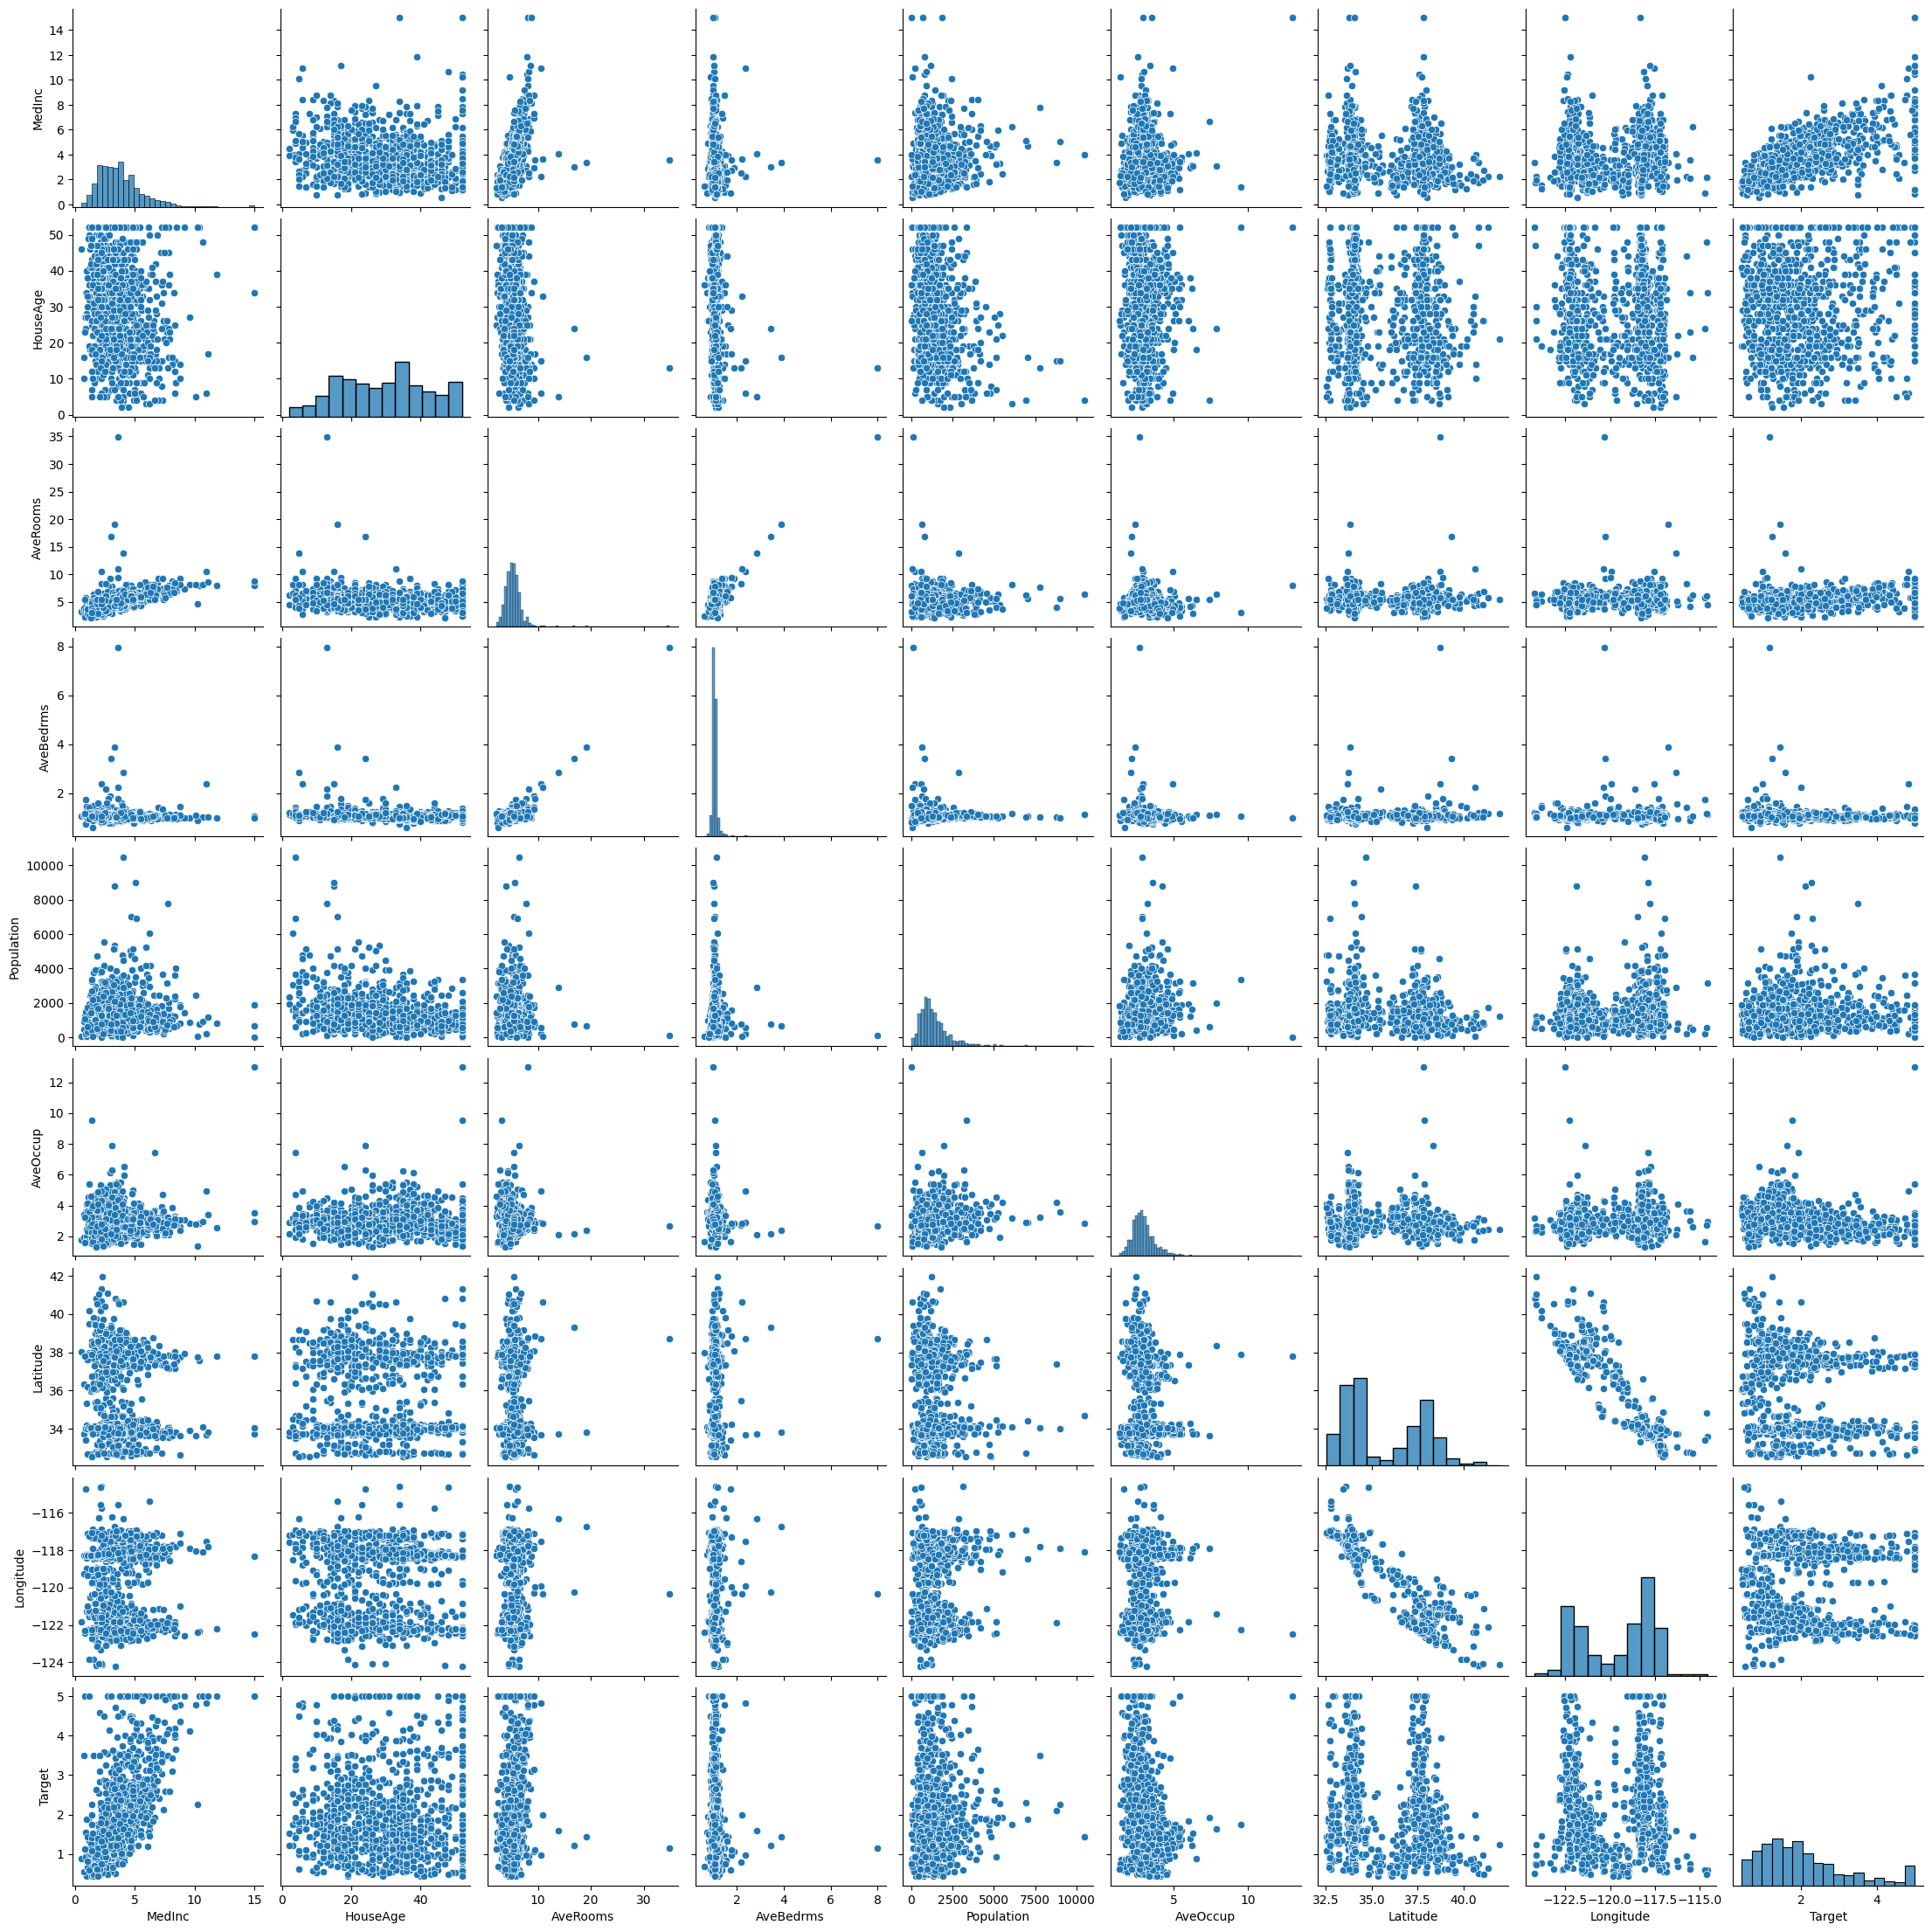

In [8]:
# 데이터 특성간 관계 시각화 
sns.pairplot(df.sample(1000))   # df에서 1000개 랜덤 샘플 추출해서 상관관계를 pairplot으로 시각화
plt.show()

In [9]:
df.shape

(20640, 9)

- feature(특성) 데이터만 스케일링 적용 후 전체 데이터는 Tensor형태로 반환

In [ ]:
import torch
import numpy as np

scaler = StandardScaler()

features = df.iloc[:, :-1].values        # 마지막 컬럼 제외한 컬럼 df[:, :-1]  ==  df.drop(columns=["Target"]).to_numpy()
target = df.iloc[:, -1:].values          # 마지막 컬럼만

print(f"features.shape: {features.shape}, target.shape: {target.shape}")

features.shape: (20640, 8), target.shape: (20640, 1)


In [15]:
features_scaled = scaler.fit_transform(features)    # features 값을 표준화
#target_scaled = scaler.transform(target)    # target 값을 표준화 (하게 되면 검증시 inverse_transform으로 값 재변경 해주고 손실계산)

print(f"features.shape: {features.shape}, target.shape: {target.shape}")

features.shape: (20640, 8), target.shape: (20640, 1)


In [16]:
data_np = np.concatenate([features_scaled, target], axis = 1)   # (feature + target) 열 방향으로 합치기
data = torch.from_numpy(data_np).float()                        # numpy 배열을 Pytorch Tensor Float로 변환

print(data.size())

torch.Size([20640, 9])


In [17]:
import torch                        # Pytorch 기본 패키지
import torch.nn as nn               # 신경망 레이어/모듈
import torch.nn.functional as F     # 활성화/손실함수 등 함수   
import torch.optim as optim         # 최적화 함수

In [18]:
x = data[:, :-1]        # 특성 데이터
y = data[:, -1:]        # 학습 데이터

print(x.size(), y.size())

torch.Size([20640, 8]) torch.Size([20640, 1])


In [19]:
# 하이퍼파라미터 설정
n_epochs = 4000         # 전체 학습 반복 횟수
batch_size = 256        # 미니배치 샘플 갯수
print_interval = 200    # 학습 로그 출력 간격
learning_rate = 1e-2    # 옵티마이저에 적용할 학습률

In [21]:
model = nn.Sequential(
    # 입력층 -> 은닉층.
    nn.Linear(x.size(-1), 6),                   # 입력 특성 수 -> 은닉층 1 (6개 노드)
    nn.LeakyReLU(),                             # LeakyReLU

    # 1번째 은닉층 -> 2번째 은닉층 ( 6 -> 5,LeakyReLU)
    nn.Linear(6, 5), 
    nn.LeakyReLU(),

    # 2번째 은닉층 -> 3번째 은닉층 ( 5 -> 4,LeakyReLU)
    nn.Linear(5, 4), 
    nn.LeakyReLU(),

    # 3번째 은닉층 -> 4번째 은닉층 ( 4 -> 3,LeakyReLU)
    nn.Linear(4, 3), 
    nn.LeakyReLU(),

    # 4번째 은닉층 -> 출력층
    nn.Linear(3, y.size(-1)), 
)


model

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)

In [23]:
# SGD 최적화함수 (최적화할 파라미터의 가중치 편향, lr )
optimzer = optim.SGD(
    model.parameters(),     # 최적화할 파라미터(모델의 가중치, 편향)
    lr = learning_rate    
)

In [24]:
from tqdm.auto import tqdm

for i in tqdm(range(n_epochs), desc = "Training"):

    indicies = torch.randperm(x.size(0))                        # 0 ~ 데이터 샘플 수 -1 인덱스를 랜덤 셔플
    x_ = torch.index_select(x, dim = 0, index = indicies)       # 셔플된 인덱스 순서대로 x 재정렬
    y_ = torch.index_select(y, dim = 0, index = indicies)       # 셔플된 인덱스 순서대로 y 재정렬

    x_ = x_.split(batch_size, dim = 0)      # 미니배치 단위로 x_ 분할 (변환타입 : 튜블)
    y_ = y_.split(batch_size, dim = 0)      # 미니배치 단위로 y_ 분할 (변환타입 : 튜블)

    y_hat = []                              # 모델의 예측값 리스트
    total_loss = 0                          # 에폭 별 전체 손실 누적

    for x_i, y_i in zip(x_, y_):            # 미니 배치 단위로 학습 
        
        y_hat_i = model(x_i)                # 순전파 : 예측값 계산
        loss = F.mse_loss(y_hat_i, y_i)     # 손실 계산 (MSE : 회귀)


        optimzer.zero_grad()    # 이전 배치의 기울기 초기화
        loss.backward()         # 역전파 : 파라미터의 기울기 계산 
        optimzer.step()         # 파라미터 업데이트 (SGD)

        total_loss += float(loss)   # float 형태로 누적
        y_hat += [y_hat_i]          # 예측값을 리스트에 저장

    total_loss = total_loss / len(x_)   # 에폭 평균 손실 계산

    if ( i + 1 ) % print_interval == 0:                 # 200번 마다 출력
        print(f"Epoch : {i + 1} loss {total_loss:.4}")
    
y_hat = torch.cat(y_hat, dim = 0)       # 미니 배치 예측값을 (N, out_dim)으로 결합
y = torch.cat(y_ ,dim = 0)              # 셔플된 y_ 미니배치도 동일한 순서로 결합

Training:   0%|          | 0/4000 [00:00<?, ?it/s]/var/folders/g7/6_f4vlmd2tnf4ghbk1n9tv_40000gn/T/ipykernel_20874/2269473546.py:25: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:837.)
  total_loss += float(loss)   # float 형태로 누적
Training:   5%|▌         | 213/4000 [00:03<00:57, 66.31it/s]

Epoch : 200 loss 0.3202


Training:  10%|█         | 409/4000 [00:06<00:56, 63.44it/s]

Epoch : 400 loss 0.3062


Training:  15%|█▌        | 612/4000 [00:10<00:53, 62.77it/s]

Epoch : 600 loss 0.2961


Training:  20%|██        | 808/4000 [00:13<00:49, 63.92it/s]

Epoch : 800 loss 0.2958


Training:  25%|██▌       | 1006/4000 [00:16<00:51, 58.63it/s]

Epoch : 1000 loss 0.2932


Training:  30%|███       | 1212/4000 [00:20<00:43, 64.12it/s]

Epoch : 1200 loss 0.2939


Training:  35%|███▌      | 1411/4000 [00:23<00:45, 56.67it/s]

Epoch : 1400 loss 0.2936


Training:  40%|████      | 1606/4000 [00:26<00:40, 59.68it/s]

Epoch : 1600 loss 0.2901


Training:  45%|████▌     | 1812/4000 [00:30<00:33, 64.75it/s]

Epoch : 1800 loss 0.2906


Training:  50%|█████     | 2008/4000 [00:33<00:32, 61.98it/s]

Epoch : 2000 loss 0.2898


Training:  55%|█████▌    | 2211/4000 [00:36<00:27, 65.60it/s]

Epoch : 2200 loss 0.29


Training:  60%|██████    | 2407/4000 [00:39<00:24, 65.00it/s]

Epoch : 2400 loss 0.2893


Training:  65%|██████▌   | 2610/4000 [00:42<00:22, 62.11it/s]

Epoch : 2600 loss 0.2888


Training:  70%|███████   | 2813/4000 [00:45<00:17, 66.24it/s]

Epoch : 2800 loss 0.2892


Training:  75%|███████▌  | 3009/4000 [00:48<00:15, 62.22it/s]

Epoch : 3000 loss 0.288


Training:  80%|████████  | 3208/4000 [00:52<00:12, 62.43it/s]

Epoch : 3200 loss 0.2876


Training:  85%|████████▌ | 3410/4000 [00:55<00:09, 60.74it/s]

Epoch : 3400 loss 0.2871


Training:  90%|█████████ | 3606/4000 [00:58<00:06, 62.07it/s]

Epoch : 3600 loss 0.2868


Training:  95%|█████████▌| 3805/4000 [01:01<00:03, 55.19it/s]

Epoch : 3800 loss 0.287


Training: 100%|██████████| 4000/4000 [01:04<00:00, 61.57it/s]

Epoch : 4000 loss 0.286


In [25]:
df = pd.DataFrame(torch.cat([y, y_hat], dim = 1).detach().numpy(),      # (y, y_hat) 을 열방향으로 붙여 numpy 변환
                  columns = ["y", "y_hat"])

.detach() : 그래디언트 추적을 끊는다. (그래프 제거)

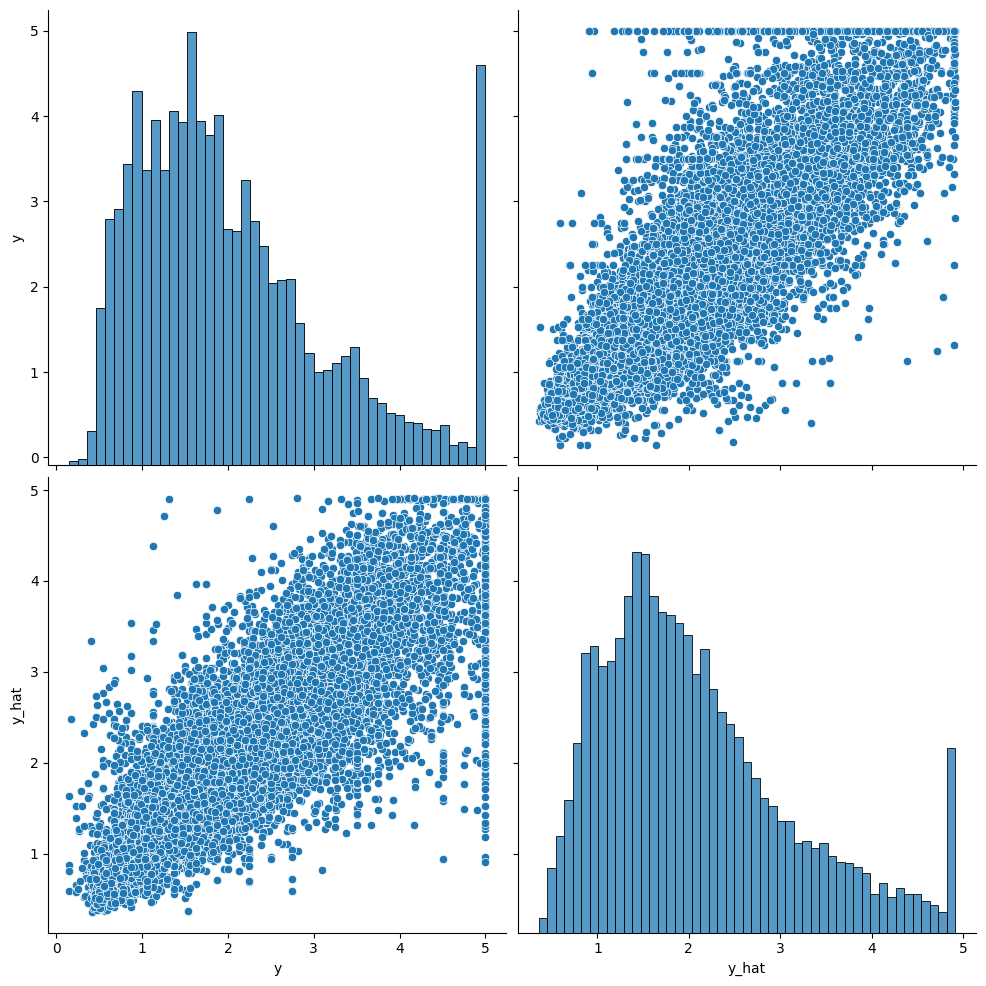

In [26]:
sns.pairplot(df, height= 5)
plt.show()


In [27]:
print(y_hat.size(),y.size())

torch.Size([20640, 1]) torch.Size([20640, 1])
